# 2SFCA script test at Middle Layer Super Output Areas (MSOA) level

In [1]:
from access import access, weights, datasets
import logging
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import mapclassify as mc
from legendgram import legendgram
import palettable.matplotlib as palmpl
import seaborn as sns
import numpy as np
from scipy import stats

# Data import

## Get LA——MSOA code data

In [2]:
LA_MSOA = pd.read_csv('LA_MSOA_code.csv')
LA_MSOA

,LA_Code_2020,LA_name_2020,MSOA Code
0,E06000001,Hartlepool,E02002483
1,E06000001,Hartlepool,E02002484
2,E06000001,Hartlepool,E02002485
3,E06000001,Hartlepool,E02002487
4,E06000001,Hartlepool,E02002488
...,...,...,...
6786,E09000033,Westminster,E02000979
6787,E09000033,Westminster,E02000980
6788,E09000033,Westminster,E02000981
6789,E09000033,Westminster,E02000982


## Get MSOA boundary data

In [3]:
MSOA=gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_github/England_basemap/MSOA_Boundary_with_population.gpkg?raw=true')
MSOA = MSOA.to_crs('epsg:27700')

<AxesSubplot:>

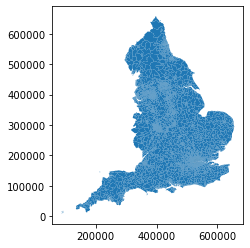

In [5]:
MSOA.plot()

## Get the population weighted centroid of MSOA (demand points)

In [4]:
MSOA_points=gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_github/England_basemap/MSOA_Population_Weighted_Centroids_with_population.gpkg?raw=true')
MSOA_points = MSOA_points.to_crs('epsg:27700')

<AxesSubplot:>

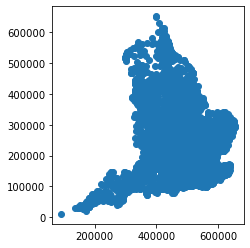

In [7]:
MSOA_points.plot()

### Calculate population over 60

In [5]:
MSOA_points['pop60+69'] = MSOA_points['pop60-69']

In [6]:
MSOA_points

,objectid,msoa11cd,pop0-49,pop50-59,pop60-69,pop70-79,pop80-89,pop90+,total_pop,geometry,pop60+69
0,1,E02002536,5688,1416,1132,891,540,104,9771,POINT (445582.345 524175.434),1132
1,2,E02002537,5578,1251,836,545,386,45,8641,POINT (446777.151 524256.841),836
2,3,E02002534,2547,824,863,967,407,85,5693,POINT (461356.929 515118.900),863
3,4,E02002535,4959,1636,1385,870,416,70,9336,POINT (446117.027 525455.836),1385
4,5,E02002532,3783,970,810,655,342,95,6655,POINT (461053.212 516175.379),810
...,...,...,...,...,...,...,...,...,...,...,...
6786,6787,E02004669,3697,1171,1156,946,433,93,7496,POINT (393469.114 227500.260),1156
6787,6788,E02006096,3893,1086,805,804,344,69,7001,POINT (332829.367 109219.836),805
6788,6789,E02003088,4007,1257,1230,1194,577,179,8444,POINT (343276.340 158947.520),1230
6789,6790,E02006070,5161,1163,906,670,316,75,8291,POINT (331710.269 136880.200),906


## read vaccination site point data (supply points)

In [7]:
site = gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_github/site_2_26_clean/vaccination_site.gpkg?raw=true')
site = site.to_crs('epsg:27700')

<AxesSubplot:>

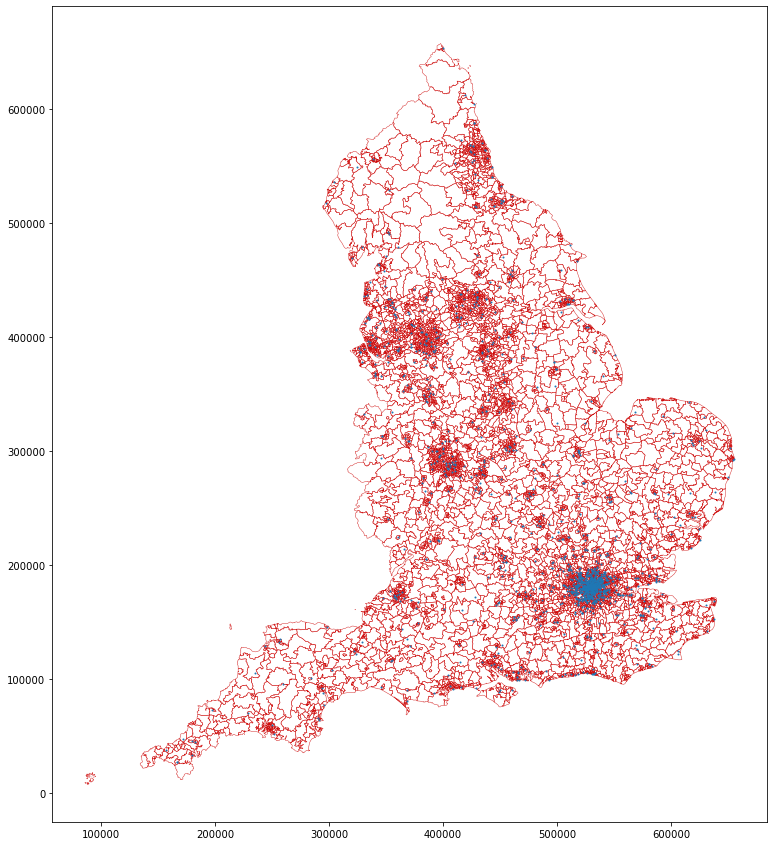

In [24]:
f,ax = plt.subplots(figsize=(15,15))
MSOA.plot(edgecolor=(0.8, 0, 0,0.8), facecolor='none', linewidth=0.5,ax=ax)
site.plot(ax=ax,markersize=1)

In [10]:
site

,index,supply_value,geometry
0,0,1,POINT (504748.029 248914.642)
1,1,1,POINT (505059.230 222903.988)
2,2,1,POINT (532504.110 176066.629)
3,3,1,POINT (532504.110 176066.629)
4,4,1,POINT (504396.617 222557.941)
...,...,...,...
1595,1595,1,POINT (196928.058 72385.978)
1596,1596,1,POINT (524814.936 172019.963)
1597,1597,1,POINT (526813.753 181129.037)
1598,1598,1,POINT (408626.628 90816.439)


There are 555158 pairs of distances that meet the requirement.

# Read in the driving distance from the point of demand to the point of supply as cost

In [8]:
distance_cost_df = pd.read_csv('https://raw.githubusercontent.com/LingruFeng/dissertation/main/data_github/distance_cost_final.csv') 
distance_cost_df = distance_cost_df.rename(columns={"Distance in meter": "cost", "origin_id": "origin", "destination_id": "dest"})
distance_cost_df

,cost,origin,dest
0,7681,E02002536,122
1,14506,E02002536,127
2,14764,E02002536,137
3,12744,E02002536,836
4,12605,E02002536,838
...,...,...,...
555153,15948,E02003088,1204
555154,7966,E02006070,1278
555155,21577,E02006679,1176
555156,10890,E02006679,1177


# Calculate the MSOAs that have no vaccination service within 10 miles distance and plot the map

In [9]:
# Get demand MSOAs that have at least one vaccination site within 10 miles of distance
distance_cost_df_test = distance_cost_df.loc[distance_cost_df['cost']<16093.44]
distance_cost_df_test

a = pd.unique(distance_cost_df_test['origin'])

# Set 'MSOA_with_supply' field True if a place has at least one vaccination site within 10 miles of distance, otherwise False.
b = pd.DataFrame()
b['MSOA'] = a
b['MSOA_with_supply'] = True

MSOA_with_supply = pd.merge(left = MSOA,right = b, how='left', left_on='MSOA11CD', right_on='MSOA')
MSOA_with_supply=MSOA_with_supply.fillna(False)

### Count the number of MSOAs that are lack of vaccination service

In [10]:
m = MSOA_with_supply[MSOA_with_supply['MSOA_with_supply']==False]
print('There are ',m['MSOA11CD'].count(),'MSOAs that are lack of vaccination service setting 10 miles as the vaccination service radius threshold.')

There are  381 MSOAs that are lack of vaccination service setting 10 miles as the vaccination service radius threshold.


### Plot the regions that are lack of service

In [14]:
# Get the boundary of England
MSOA_with_supply['dissolve']=1
MSOA_outline = MSOA_with_supply.dissolve(by='dissolve')

Text(0.5, 1.0, 'MSOAs Lack of Vaccination Service')

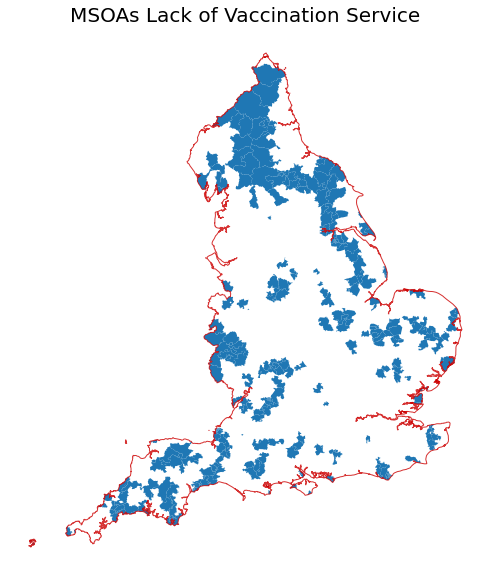

In [15]:
# Plot the map
f,ax = plt.subplots(figsize=(10,10))
m.plot(figsize = (10,10),ax=ax)
MSOA_outline.plot(edgecolor=(0.8, 0, 0,0.8), facecolor='none', linewidth=1,ax=ax)
ax.axis('off')
ax.set_title('MSOAs Lack of Vaccination Service', fontdict={'fontsize':'20', 'fontweight':'3'})

# Create a dataframe for the accessibility calculation using the Driving distance from the point of demand to the point of supply as cost

In [11]:
fca = access(demand_df = MSOA_points,
           demand_index='msoa11cd',
           demand_value='pop60+69',
           supply_df= site,
           supply_index= 'index',
           supply_value=['supply_value'],
           cost_df              = distance_cost_df,
           cost_origin          = 'origin',
           cost_dest            = 'dest',
           cost_name            = 'cost',
           neighbor_cost_df     = distance_cost_df,
           neighbor_cost_origin = 'origin',
           neighbor_cost_dest   = 'dest',
           neighbor_cost_name   = 'cost')

### 2SFCA

In [12]:
# Using 2SFCA method, 16093.44 meters (10 miles) is used as service threshold radius to calculate the accessibility
fca.two_stage_fca(name = "2sfca",max_cost = 16093.44)

,2sfca_supply_value
msoa11cd,
E02000001,0.002315
E02000002,0.000409
E02000003,0.000387
E02000004,0.000278
E02000005,0.000382
...,...
E02006930,0.001539
E02006931,0.001672
E02006932,0.000194


### E2SFCA

#### Set distance decay weight using gaussian function.

In [13]:
# Define a gaussian weight. Here, set the σ to be 5364.48 (meters), which is one third of the threshold, such that we'll be at the 3σ level at 16093.44 meters.
# 用3σ原理解释参数的选择 (According to the the empirical rule, also referred to as the three-sigma rule,
# for a normal distribution, almost all observed data will fall within three standard deviations.因此当距离接近threshold时，weight趋近于0)
gaussian = weights.gaussian(sigma =5364.48)
gaussian

fca.enhanced_two_stage_fca(name = "E2sfca", weight_fn = gaussian)

,E2sfca_supply_value
msoa11cd,
E02000001,0.003525
E02000002,0.000358
E02000003,0.000361
E02000004,0.000264
E02000005,0.000411
...,...
E02006930,0.001357
E02006931,0.001464
E02006932,0.000134


### 3SFCA

In [14]:
fca.three_stage_fca(name = "3sfca", weight_fn = gaussian)

,3sfca_supply_value
msoa11cd,
E02000001,0.002857
E02000002,0.000392
E02000003,0.000390
E02000004,0.000300
E02000005,0.000435
...,...
E02006930,0.001245
E02006931,0.001372
E02006932,0.000098


### Rational agent access model (RAAM)

In [15]:
fca.raam(name = "raam", tau = 16093.44);

## See the result

In [16]:
fca.access_df

,pop60+69,2sfca_supply_value,E2sfca_supply_value,3sfca_supply_value,raam_supply_value
msoa11cd,,,,,
E02000001,1025,0.002315,0.003525,0.002857,0.101581
E02000002,505,0.000409,0.000358,0.000392,0.948133
E02000003,886,0.000387,0.000361,0.000390,0.913782
E02000004,598,0.000278,0.000264,0.000300,1.080389
E02000005,629,0.000382,0.000411,0.000435,0.946543
...,...,...,...,...,...
E02006930,473,0.001539,0.001357,0.001245,0.423740
E02006931,672,0.001672,0.001464,0.001372,0.347028
E02006932,173,0.000194,0.000134,0.000098,2.560687


In [17]:
fca.access_df.describe()

,pop60+69,2sfca_supply_value,E2sfca_supply_value,3sfca_supply_value,raam_supply_value
count,6791.000000,6410.000000,6.642000e+03,6.642000e+03,6642.000000
mean,870.059638,0.000329,3.204104e-04,3.169501e-04,2.081304
std,251.121854,0.000468,5.205855e-04,4.708697e-04,1.043183
min,90.000000,0.000013,2.849738e-22,3.218032e-22,0.042990
25%,696.000000,0.000114,8.610936e-05,8.329739e-05,1.482328
50%,839.000000,0.000171,1.667690e-04,1.643447e-04,2.077850
75%,1018.000000,0.000258,2.865069e-04,2.955562e-04,2.663540
max,2082.000000,0.002375,3.757613e-03,3.007151e-03,7.746315


# Show the accessibility/vaccination rate result on map

In [18]:
MSOA_fca = pd.merge(left=MSOA, right=fca.access_df, how='left', left_on='MSOA11CD', right_on='msoa11cd')
MSOA_fca=MSOA_fca.fillna(0)
MSOA_fca = MSOA_fca.rename(columns={"2sfca_supply_value": "2sfca", "E2sfca_supply_value": "E2sfca", 
                                    "3sfca_supply_value": "3sfca", "raam_supply_value": "raam"})

## Use min-max normalization to normalize the accessibility score

In [19]:
MSOA_fca['2sfca_normalized'] = (MSOA_fca['2sfca']-MSOA_fca['2sfca'].min())/(MSOA_fca['2sfca'].max()-MSOA_fca['2sfca'].min())
MSOA_fca['E2sfca_normalized'] = (MSOA_fca['E2sfca']-MSOA_fca['E2sfca'].min())/(MSOA_fca['E2sfca'].max()-MSOA_fca['E2sfca'].min())
MSOA_fca['3sfca_normalized'] = (MSOA_fca['3sfca']-MSOA_fca['3sfca'].min())/(MSOA_fca['3sfca'].max()-MSOA_fca['2sfca'].min())
MSOA_fca['raam_normalized'] = (MSOA_fca['raam']-MSOA_fca['raam'].min())/(MSOA_fca['raam'].max()-MSOA_fca['raam'].min())
MSOA_fca['raam_inverse_normalize'] = 1-MSOA_fca['raam_normalized']

In [20]:
# Read the vaccination population data
url = 'vaccination_number_2020_12_8_2021_3_7.csv'
vaccination_pop = pd.read_csv(url)
vaccination_pop

,MSOA_code,under60,over60_64,over65_69,over70_74,over75_79,over80
0,E02002796,741,323,393,426,352,458
1,E02002797,796,410,411,521,468,872
2,E02002798,1422,687,530,511,308,369
3,E02002799,937,262,196,205,158,234
4,E02002800,782,342,331,375,293,515
...,...,...,...,...,...,...,...
6786,E02002478,754,280,285,275,198,207
6787,E02002479,1016,387,518,469,432,438
6788,E02002480,563,291,374,304,270,314
6789,E02002481,797,350,348,308,227,360


In [21]:
vaccination_pop['60-69'] = vaccination_pop['over60_64'] + vaccination_pop['over65_69']

# merge the population data
MSOA_fca = pd.merge(left = MSOA_fca, right=vaccination_pop, how='left', left_on='MSOA11CD', right_on='MSOA_code')

# merge the LA information
MSOA_fca = pd.merge(left = MSOA_fca, right=LA_MSOA, how='left', left_on='MSOA11CD', right_on='MSOA Code')
MSOA_fca

,MSOA11CD,MSOA11NM,pop0-49,pop50-59,pop60-69,pop70-79,pop80-89,pop90+,total_pop,geometry,...,under60,over60_64,over65_69,over70_74,over75_79,over80,60-69,LA_Code_2020,LA_name_2020,MSOA Code
0,E02000001,City of London 001,6206,1339,1025,720,313,118,9721,"POLYGON ((532947.881 181895.061, 533412.520 18...",...,734,235,312,300,197,245,547,E09000001,City of London,E02000001
1,E02000002,Barking and Dagenham 001,5621,835,505,401,268,105,7735,"POLYGON ((549002.599 190873.761, 549122.828 18...",...,911,148,170,170,161,297,318,E09000002,Barking and Dagenham,E02000002
2,E02000003,Barking and Dagenham 002,8062,1272,886,575,301,78,11174,"POLYGON ((548956.371 189063.484, 549087.474 18...",...,1200,297,293,277,206,325,590,E09000002,Barking and Dagenham,E02000003
3,E02000004,Barking and Dagenham 003,4401,866,598,444,262,116,6687,"POLYGON ((551945.701 186027.855, 551672.764 18...",...,891,248,222,205,173,285,470,E09000002,Barking and Dagenham,E02000004
4,E02000005,Barking and Dagenham 004,7982,1144,629,413,211,53,10432,"POLYGON ((549420.553 187442.648, 548985.314 18...",...,1308,240,217,202,148,216,457,E09000002,Barking and Dagenham,E02000005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6786,E02006930,Greenwich 037,7425,741,473,305,167,16,9127,"POLYGON ((540585.068 178133.897, 540368.424 17...",...,1430,177,202,162,109,122,379,E09000011,Greenwich,E02006930
6787,E02006931,Greenwich 038,7267,1024,672,510,255,78,9806,"POLYGON ((538775.968 177841.277, 539072.243 17...",...,938,285,258,254,181,244,543,E09000011,Greenwich,E02006931
6788,E02006932,Liverpool 060,16963,264,173,80,25,10,17515,"POLYGON ((335757.632 390987.474, 335739.219 39...",...,1314,61,76,62,39,33,137,E08000012,Liverpool,E02006932
6789,E02006933,Liverpool 061,7130,603,485,220,97,4,8539,"POLYGON ((335096.788 389638.891, 334715.024 38...",...,1296,181,195,169,94,82,376,E08000012,Liverpool,E02006933


In [22]:
MSOA_fca['vaccination_percentage_for60+69'] = MSOA_fca['60-69']/MSOA_fca['pop60+69']

# Set vaccination rate greater than 1 to 1
MSOA_fca['vaccination_rate_60+69']= np.where(MSOA_fca['vaccination_percentage_for60+69']>1, 1, MSOA_fca['vaccination_percentage_for60+69'])

In [23]:
# Subset the columns to only needed ones
MSOA_fca = MSOA_fca[['LA_Code_2020','LA_name_2020','MSOA11CD','MSOA11NM','pop60+69','60-69',
                     'vaccination_rate_60+69',
                     '2sfca','2sfca_normalized',
                     'E2sfca','E2sfca_normalized',
                     '3sfca','3sfca_normalized',
                     'raam','raam_normalized','raam_inverse_normalize',
                     'geometry']]

<AxesSubplot:>

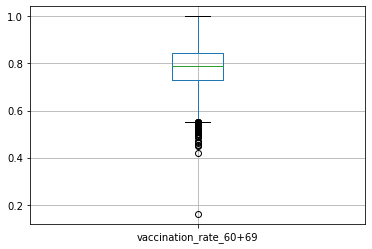

In [35]:
MSOA_fca.boxplot('vaccination_rate_60+69')

## Map plot code

In [24]:
# for Accessibility (continuous)
def access(access_metric):
    base = MSOA_fca.plot(access_metric, legend = True, 
                         figsize = (10,10), 
                         cmap = "magma", 
                         markersize = .5, 
                         alpha = 1,
                         vmin = MSOA_fca[access_metric].quantile(0.05), vmax = MSOA_fca[access_metric].quantile(0.95))
    base.axis('off')
    base.set_title('England Vaccination Accessibility', fontdict={'fontsize':'20', 'fontweight':'3'})

In [25]:
# for Accessibility (natural break)
def access_break(column):
    f,ax = plt.subplots(figsize=(10,10))
    MSOA_fca.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    ax.axis('off') 
    ax.set_title('England Vaccination Accessibility', fontdict={'fontsize':'20', 'fontweight':'3'})

    ax.get_legend().set_title("Accessbility")

    q = mc.NaturalBreaks(MSOA_fca[column], k=7)
    legendgram(f, ax, 
                MSOA_fca[column], q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False)

In [43]:
# for Vaccination Rate (continuous)
def pop_rate(access_metric):
    base = MSOA_fca.plot(access_metric, legend = True, 
                         figsize = (10,10), 
                         cmap = "magma", 
                         markersize = .5, 
                         alpha = 1,
                         vmin = MSOA_fca[access_metric].quantile(0.05), vmax = MSOA_fca[access_metric].quantile(0.95))
    base.axis('off')
    base.set_title('England Vaccination Rate in 60-69 by MSOA', fontdict={'fontsize':'20', 'fontweight':'3'})
    #site.plot(ax=base, markersize=1, color='red')

In [44]:
# for Vaccination Rate (natural break)
def pop_rate_break(column):
    f,ax = plt.subplots(figsize=(10,10))
    MSOA_fca.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    ax.axis('off') 
    ax.set_title('England Vaccination Rate in 60-69 by MSOA', fontdict={'fontsize':'20', 'fontweight':'3'})

    ax.get_legend().set_title("Vaccination Rate")

    q = mc.NaturalBreaks(MSOA_fca[column], k=7)
    legendgram(f, ax, 
                MSOA_fca[column], q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False)

In [45]:
# Get the London boundary map for more conplex map plot 
# Read some London Boundary data for map show
# An intricate map of London's borders
borough = gpd.read_file('https://github.com/LingruFeng/0006_DSSS_assessment/blob/main/London_Boroughs.gpkg?raw=true')
borough = borough.to_crs('epsg:27700')
London = pd.merge(left = MSOA_fca, right=borough[['gss_code','objectid']],how = 'left', left_on='LA_Code_2020', right_on='gss_code')
London = London.dropna()
London['London'] = 'London'
London_boundary = London.dissolve(by='London')

# A rough map of the borders of London
inner=gpd.read_file('https://github.com/LingruFeng/i2p_assessment3/blob/main/inner_outer.gpkg?raw=true')
inner = inner.to_crs('epsg:27700')
inner = inner.dissolve(by='Source')

In [46]:
# for Vaccination Rate (break) with London zooming in
def pop_rate_break_1(column):
    f,ax = plt.subplots(figsize=(13,13))
    MSOA_fca.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    inner.plot(edgecolor=(0.8, 0, 0,0.8), facecolor='none', linewidth=1, ax=ax)
    ax.axis('off') 
    ax.set_title('England Vaccination Rate in 60-69 by MSOA', fontdict={'fontsize':'20', 'fontweight':'3'})
    
    ax.get_legend().set_title("Vaccination Rate")
    ax.get_legend().get_title().set_fontsize('15')
    
    ax.text(x=140000, y=590000, s='N', fontsize=30)
    ax.arrow(150000, 530000, 0, 60000, length_includes_head=True,
          head_width=20000, head_length=80000, overhang=.1, facecolor='k')
    
    ax2 = f.add_axes([0.1, 0.35, 0.3, 0.3])
    MSOA_fca.plot(column=column,edgecolor='None', scheme='NaturalBreaks',k=7,legend=False,ax=ax2)
    ax2.set_xlim([502300,562800])
    ax2.set_ylim([154800,201800])
    ax2.set_title('London', fontdict={'fontsize':'20', 'fontweight':'3'})
    London_boundary.plot(edgecolor=(0.8, 0, 0,0.8), facecolor='none', linewidth=1, ax=ax2)
    ax2.axis('off')

    q = mc.NaturalBreaks(MSOA_fca[column], k=7)
    legendgram(f, ax, 
                MSOA_fca[column], q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False)

In [47]:
# for Vaccination accessibility (break) with London zooming in
def access_break_1(column):
    f,ax = plt.subplots(figsize=(13,13))
    MSOA_fca.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    inner.plot(edgecolor=(0.8, 0, 0,0.8), facecolor='none', linewidth=1, ax=ax)
    ax.axis('off') 
    ax.set_title('England Vaccination Accessibility in 60-69 by MSOA', fontdict={'fontsize':'20', 'fontweight':'3'})
    
    ax.get_legend().set_title("Accessibility")
    ax.get_legend().get_title().set_fontsize('15')
    
    ax.text(x=140000, y=590000, s='N', fontsize=30)
    ax.arrow(150000, 530000, 0, 60000, length_includes_head=True,
          head_width=20000, head_length=80000, overhang=.1, facecolor='k')
    
    ax2 = f.add_axes([0.1, 0.35, 0.3, 0.3])
    MSOA_fca.plot(column=column,edgecolor='None', scheme='NaturalBreaks',k=7,legend=False,ax=ax2)
    ax2.set_xlim([502300,562800])
    ax2.set_ylim([154800,201800])
    ax2.set_title('London', fontdict={'fontsize':'20', 'fontweight':'3'})
    London_boundary.plot(edgecolor=(0.8, 0, 0,0.8), facecolor='none', linewidth=1, ax=ax2)
    ax2.axis('off')

    q = mc.NaturalBreaks(MSOA_fca[column], k=7)
    legendgram(f, ax, 
                MSOA_fca[column], q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False)

In [48]:
# for London Vaccination Rate map only
def pop_rate_break_London(column):
    f,ax = plt.subplots(figsize=(10,10))
    London.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    ax.axis('off') 
    ax.set_title('London Vaccination Rate in 60-69 by MSOA', fontdict={'fontsize':'20', 'fontweight':'3'})

    ax.get_legend().set_title("Vaccination Rate")

    q = mc.NaturalBreaks(London[column], k=7)
    legendgram(f, ax, 
                London[column], q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False)

In [49]:
# for London accessibility map only
def access_break_London(column):
    f,ax = plt.subplots(figsize=(10,10))
    London.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    ax.axis('off') 
    ax.set_title('London Vaccination Accessibility in 60-69 by MSOA', fontdict={'fontsize':'20', 'fontweight':'3'})

    ax.get_legend().set_title("Accessibility")

    q = mc.NaturalBreaks(London[column], k=7)
    legendgram(f, ax, 
                London[column], q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False)

## Accessibility (When the service radius is 10 miles driving distance)

### 2SFCA

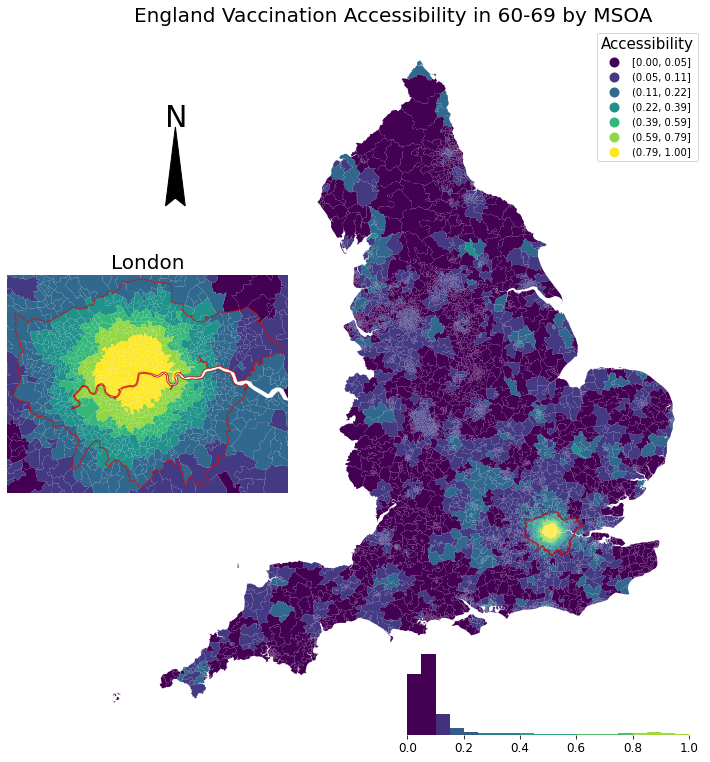

In [50]:
access_break_1('2sfca_normalized')

### E2SFCA

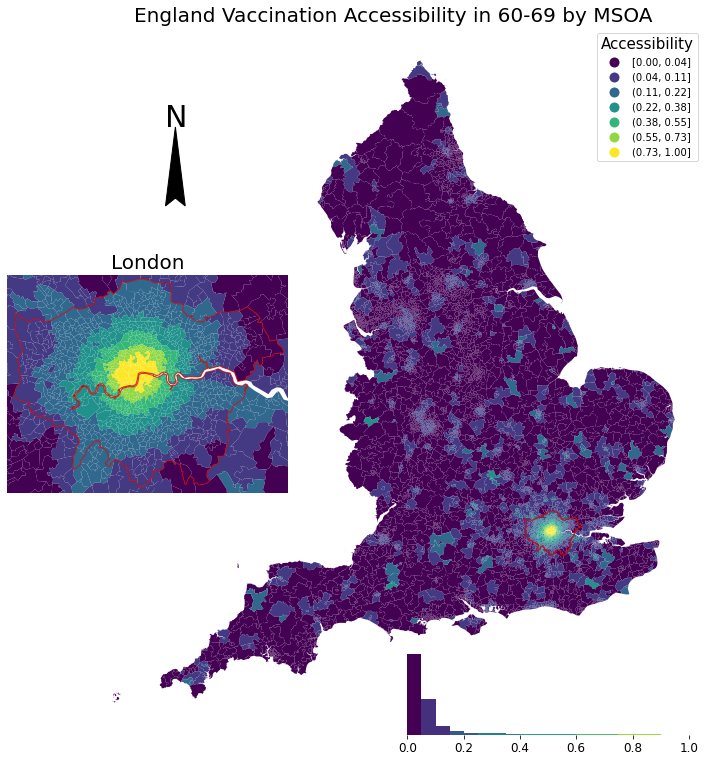

In [51]:
access_break_1('E2sfca_normalized')

### 3SFCA

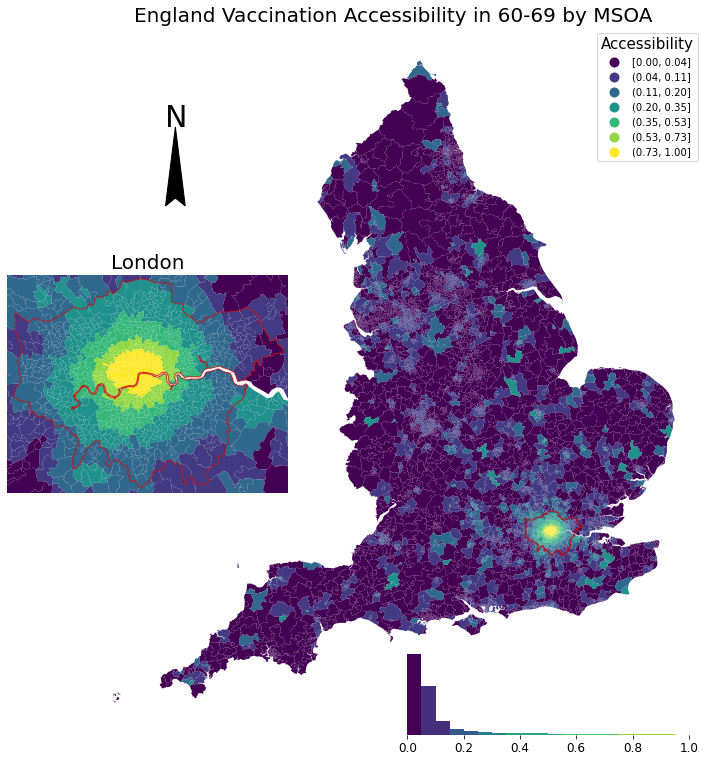

In [52]:
access_break_1('3sfca_normalized')

### RAAM

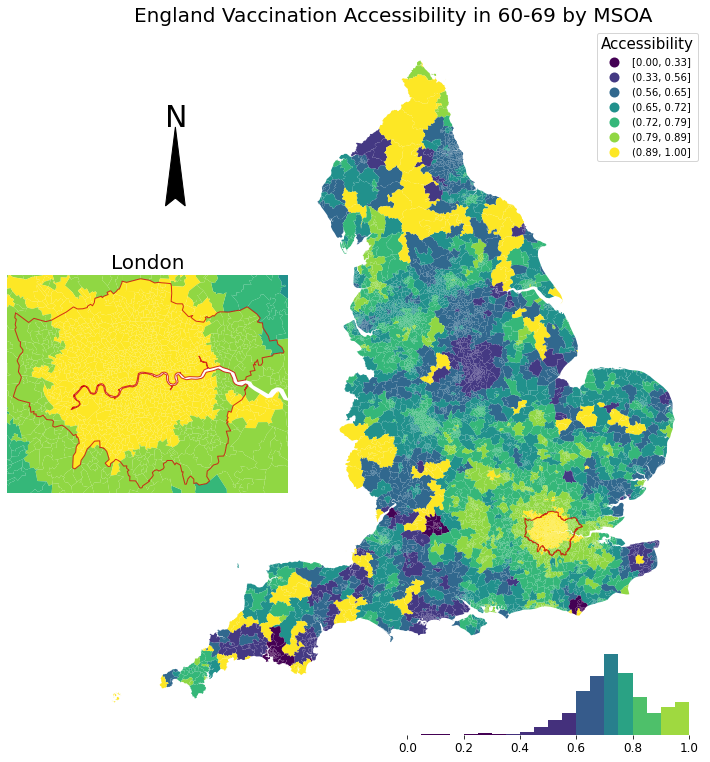

In [53]:
access_break_1('raam_inverse_normalize')

## Vaccination Rate

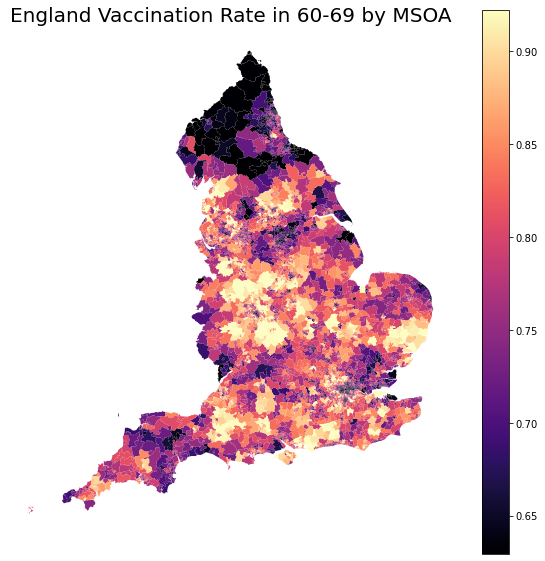

In [54]:
pop_rate('vaccination_rate_60+69')

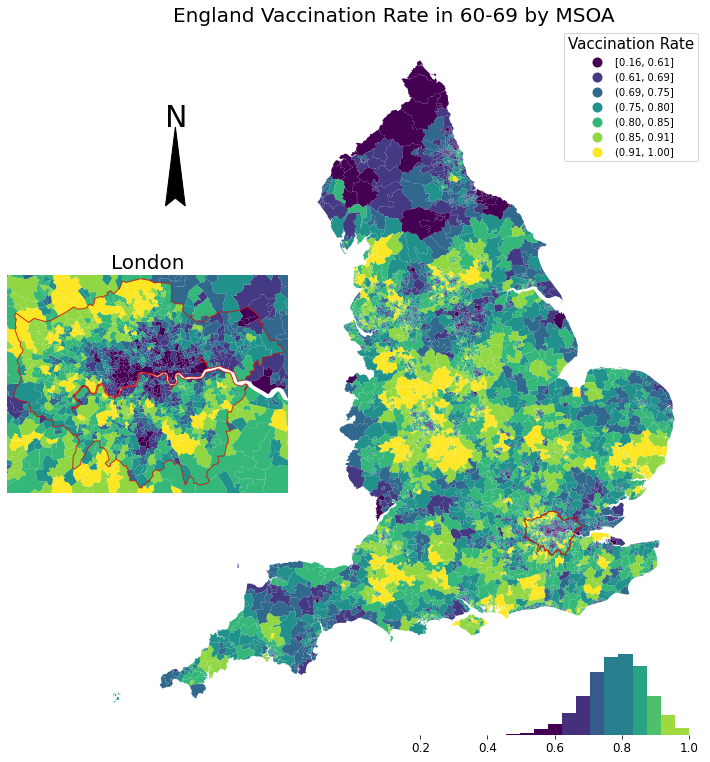

In [55]:
pop_rate_break_1('vaccination_rate_60+69')

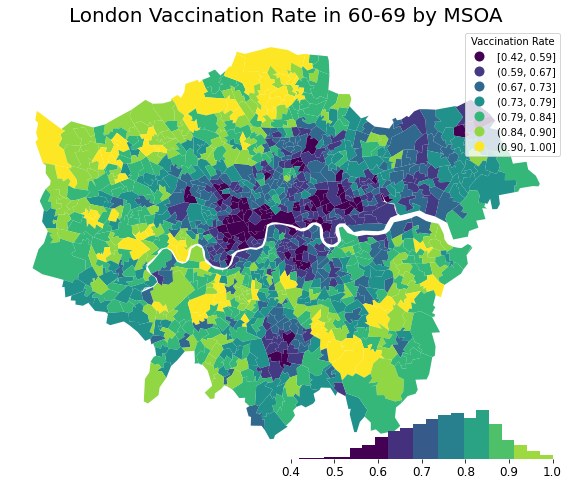

In [56]:
pop_rate_break_London('vaccination_rate_60+69')

# Calculate Pearson and Spearman correlation coefficient of accessibility and vaccination rate

### 2SFCA

In [57]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['2sfca_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['2sfca_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: -0.20503688514225873
p-value: 2.2710056930811367e-65


In [58]:
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['2sfca_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['2sfca_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Spearman correlation coefficient: -0.027297916476596913
p-value: 0.024476967748787916


### E2SFCA

In [59]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['E2sfca_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['E2sfca_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: -0.2328842541039836
p-value: 2.5933202405073106e-84


In [60]:
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['E2sfca_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['E2sfca_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Spearman correlation coefficient: -0.07197117089262052
p-value: 2.8926894314942927e-09


### 3SFCA

In [61]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['3sfca_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['3sfca_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: -0.21659164842355919
p-value: 6.548667024290544e-73


In [62]:
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['3sfca_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['3sfca_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Spearman correlation coefficient: -0.05564822232134354
p-value: 4.463489596783318e-06


### RAAM

In [63]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['raam_inverse_normalize'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['raam_inverse_normalize'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: -0.06709842719236428
p-value: 3.1187685649887144e-08


In [64]:
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['raam_inverse_normalize'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['raam_inverse_normalize'], MSOA_fca['vaccination_rate_60+69'])[1])

Spearman correlation coefficient: -0.03694426432062409
p-value: 0.0023270790197882888


# draw a scatter plot between accessibility and vaccination rate

In [65]:
def scatter_plot(accesstype):
    plot = pd.DataFrame()
    plot['Accessibility'] = MSOA_fca[accesstype]
    plot['Vaccination Rate'] = MSOA_fca['vaccination_rate_60+69']
    plt.style.use('ggplot')
    plt.figure(figsize=(10, 6))
    a = sns.scatterplot(data=plot, x="Accessibility", y="Vaccination Rate",s=10)
    a.axes.set_title("Scatter Plot Between Accessibility and Vaccination Rate",fontsize=20)
    a.set_xlabel("Accessibility",fontsize=15)
    a.set_ylabel("Vaccination Rate",fontsize=+15)

In [66]:
def pair(accesstype):
    plot = pd.DataFrame()
    plot['Accessibility'] = MSOA_fca[accesstype]
    plot['Vaccination Rate'] = MSOA_fca['vaccination_rate_60+69']
    g = sns.pairplot(plot,plot_kws={"s": 10})
    g.fig.set_size_inches(10,7)
    g.fig.suptitle("Pair Plot Between Accessibility and Vaccination Rate", y=1.05,x=0.55,fontsize=20)

### 2SFCA

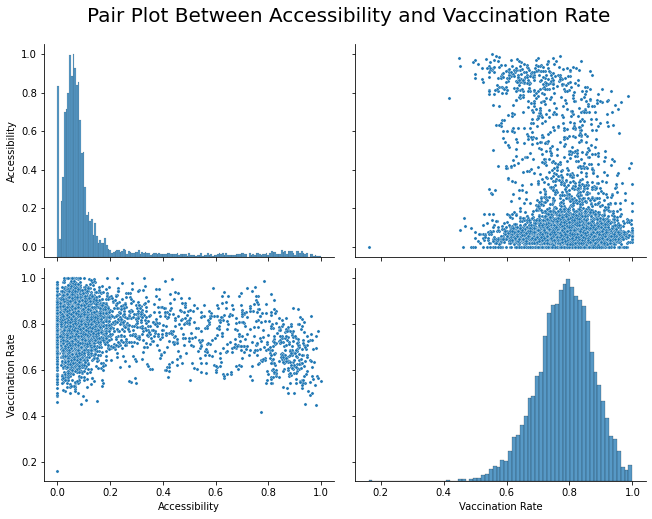

In [67]:
pair('2sfca_normalized')

### E2SFCA

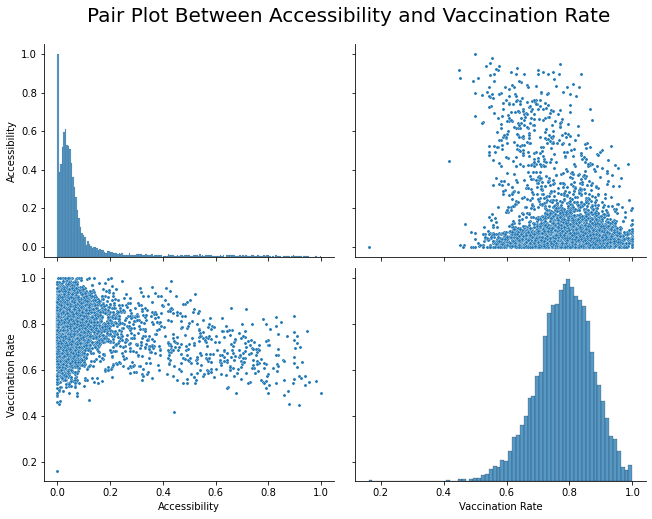

In [68]:
pair('E2sfca_normalized')

### 3SFCA

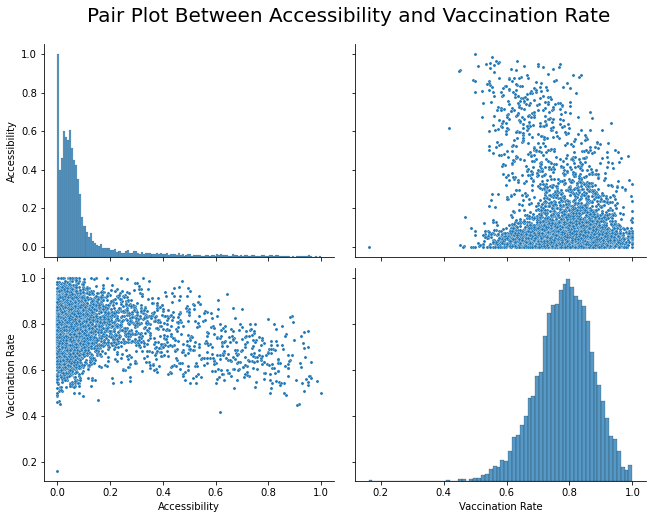

In [69]:
pair('3sfca_normalized')

### RAAM

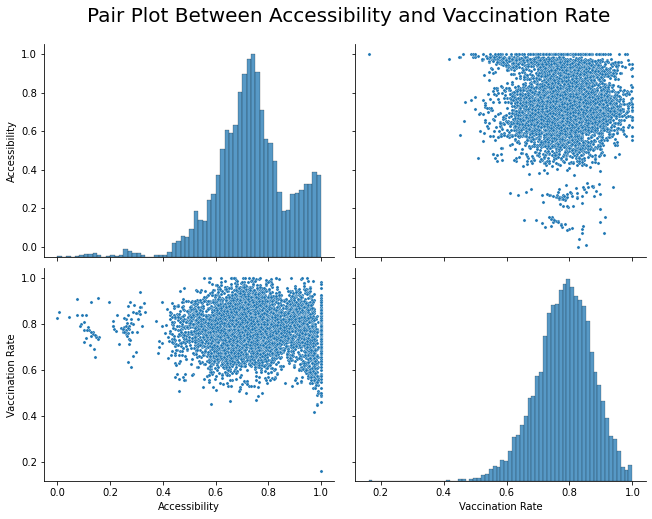

In [70]:
pair('raam_inverse_normalize')

In [55]:
#ax1 = plot.plot.scatter(x='Accessibility',
#                        y='Vaccination Rate',
#                        figsize = (10,6),
#                        fontsize = 15,s=10)
#plt.title("Scatter Plot between Accessibility and Vaccination Rate",fontsize=20)
#plt.xlabel("Accessibility",fontsize=15)
#plt.ylabel("Vaccination Rate",fontsize=15)